# Prototyping: Control with Linear Function Approximation

Our aim is to carry out RL tasks when rewards are delayed (aggregate, and anonymous), using linear function approximation.
To solve this problem, we aim to project both large discrete states and continuous states into basis vectors.


In this notebook, we test policy control with linear function approximation, using a select set of environments .
These environments have either discrete r continuous states, and discrete actions.

The environments and their best encoding for reward estimation from previous analyses are:

  - GridWorld: Tiling(8, HT=512)
  - RedGreen: Tiling(2)
  - MountainCar: Tiling(4)
  - GEM:Finite-CC-PMSM-v0 (Gym Electric Motor): Scaled raw features

We cannot know whether a feature encoding that is suitable for estimating the rewards from aggregate samples is equally adequate to represente state for learning an action-value function in control (nor a state-value in the case of policy evaluation).
So, for each, we also use a second encoding as a reference for comparison: 

  - GridWorld: Random Binary Vectors
  - RedGreen: Random Binary Vectors
  - MountainCar: Gaussian Mixture(covariance_type='diag', n_components=3)
  - GEM:Finite-CC-PMSM-v0 (Gym Electric Motor): GaussianMixture(covariance_type='diag', n_components=11)



In [33]:
import math
import random
import itertools
from typing import Sequence


In [2]:
import gymnasium as gym
import numpy as np
import pandas as pd


In [21]:
import seaborn as sns

In [3]:
from drmdp import envs, feats

## Control with SARSA

In [4]:
def action_values(
    observation, actions: Sequence[int], weights, feat_transform: feats.FeatTransform
):
    observations = [observation] * len(actions)
    state_action_m = feat_transform.batch_transform(observations, actions)
    return np.dot(state_action_m, weights), state_action_m

In [5]:
def semi_gradient_sarsa(
    env, alpha: float, gamma: float, 
    epsilon: float, num_episodes: int, 
    feat_transform: feats.FeatTransform,
    verbose: bool = True
):
    actions = tuple(range(env.action_space.n))
    weights = np.zeros(feat_transform.output_shape, dtype=np.float64)
    returns = []
    
    for i in range(num_episodes):
        obs, _ = env.reset()
        state_qvalues, gradients = action_values(obs, actions, weights, feat_transform)
        rewards = 0
        # choose action
        if random.random() <= epsilon:
            action = env.action_space.sample()
        else:
            action = np.random.choice(np.flatnonzero(state_qvalues == state_qvalues.max()))

        while True:
            # greedy            
            next_obs, reward, term, trunc, _,  = env.step(action)
            rewards += reward
            
            if term or trunc:
                weights = weights + alpha * (reward - state_qvalues[action]) * gradients[action]
                break

            next_state_qvalues, next_gradients = action_values(next_obs, actions, weights, feat_transform)
            
            if random.random() <= epsilon:
                next_action = env.action_space.sample()
            else:
                # greedy
                next_action = np.random.choice(np.flatnonzero(next_state_qvalues == next_state_qvalues.max()))

            weights = weights + alpha * (
                reward + gamma * next_state_qvalues[next_action] - state_qvalues[action]
            ) * gradients[action]
            obs = next_obs
            action = next_action
            state_qvalues = next_state_qvalues
            gradients = next_gradients
        returns.append(rewards)
        if verbose and (i+1) % math.floor(num_episodes/5) == 0:
            print("Episode", i+1, "mean returns:", np.mean(returns))
    return weights

In [6]:
def play(env, weights, num_episodes: int, feat_transform):
    actions = tuple(range(env.action_space.n))
    returns = []
    for i in range(num_episodes):
        obs, _ = env.reset()
        rewards = 0
        while True:
            state_qvalues, _ = action_values(obs, actions, weights, feat_transform)
            action = np.random.choice(np.flatnonzero(state_qvalues == state_qvalues.max()))
            next_obs, reward, term, trunc, _,  = env.step(action)
            rewards += reward
            obs = next_obs
            if term or trunc:
                returns.append(rewards)
                break
    return returns

In [7]:
def control_and_evaluate(
    env_name, args, alpha: float = 0.001, epsilon: float = 0.1, num_episodes: int = 5000, turns: int = 10, eval_max_steps: int = 1000
):
    env = envs.make(env_name)
    print("Env:", env)
    rows = []
    for kwargs in args:
        print("Control with Fn Approx - SARSA:", kwargs)
        for turn in range(turns):
            print("Turn", turn+1)
            ft_tfx = feats.create_feat_transformer(env, **kwargs)
            print("ft-tfx:", vars(ft_tfx))
            weights = semi_gradient_sarsa(
                env, alpha=alpha, gamma=1.0, epsilon=epsilon, 
                num_episodes=num_episodes, feat_transform=ft_tfx,
            )
            returns = play(
                gym.wrappers.TimeLimit(env, max_episode_steps=eval_max_steps), 
                weights=weights, num_episodes=20, 
                feat_transform=ft_tfx
            )
            print("Eval (mean) returns:", np.mean(returns))
            rows.append({
                "env": env_name,
                "args": kwargs,
                "returns": returns,
                "turn": turn
            })
    return pd.DataFrame(rows).explode("returns")

In [17]:
%%time
env = envs.make("MountainCar-v0", max_episode_steps=2500)
feats_tfx = feats.create_feat_transformer(env, **{"name": "tiles", "tiling_dim": 8, "hash_dim": 512})
weights = np.zeros(feats_tfx.output_shape)
returns = play(env, weights, num_episodes=100, feat_transform=feats_tfx)

CPU times: user 15.8 s, sys: 64.4 ms, total: 15.9 s
Wall time: 15.9 s


In [16]:
returns[-10:]

[-6774.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -9539.0]

In [18]:
rng = np.random.default_rng()

<Axes: ylabel='Count'>

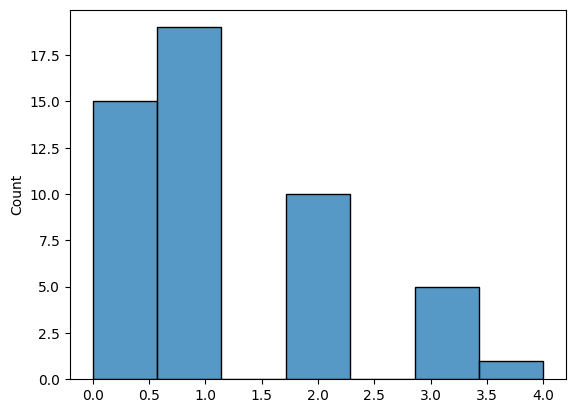

In [22]:
sns.histplot(rng.poisson(lam=1, size=50))

<Axes: ylabel='Count'>

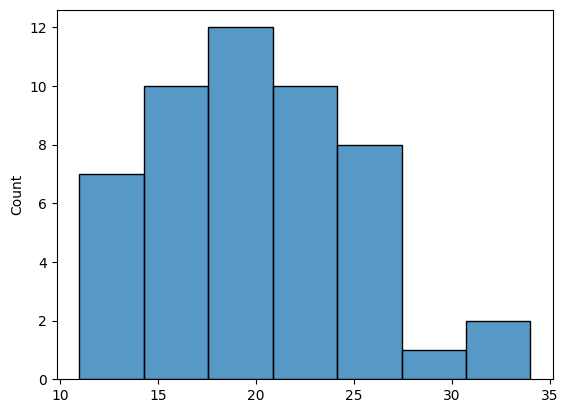

In [30]:
sns.histplot(rng.poisson(lam=20, size=50))

In [39]:
def pow2geq(lb: int) -> int:
    exp = 1
    rs = 1
    while True:
        rs = 2**exp
        if rs >= lb:
            break
        exp += 1
    return rs


In [38]:
actions = tuple(range(8))
options = []
for i in range(2, len(actions)):
    options.extend(itertools.permutations(actions, i))
len(options)

69272

In [69]:
# build a tree of options, keyed on delay
actions = tuple(range(8))
options_mapping = {}
for i in range(2, 15):
    options_mapping[i] = tuple(itertools.permutations(actions, i))
    print(i, len(options_mapping[i]))
len(options_mapping)

2 56
3 336
4 1680
5 6720
6 20160
7 40320
8 40320
9 0
10 0
11 0
12 0
13 0
14 0


13

In [86]:
def bits_required(n: int) -> int:
    """
    Returns the number of bits required to represent an integer in binary
    """
    if n == 0:
        return 1
    return len(bin(abs(n))[2:]) 

In [90]:
size = 0
delay = 10
for i in range(2, 10):
    n = 8 ** i
    size += n
    print(i, n)


bits_required(size)

2 64
3 512
4 4096
5 32768
6 262144
7 2097152
8 16777216
9 134217728


28

In [89]:
bin(abs(47))[2:]

'101111'

In [42]:
tiling_dim = 8
obs_dim = 10
num_tilings = pow2geq(obs_dim * 4)
max_size = (
    tiling_dim ** obs_dim
    * num_tilings
    * len(options)
)
max_size

4760335592456192

In [52]:
from scipy.stats import poisson, norm
import math

def poisson_confidence_interval(lmbda, confidence=0.95):
    # Calculate the Z-value for the desired confidence level
    z = norm.ppf(1 - (1 - confidence) / 2)
    
    # Calculate the lower and upper bounds using the normal approximation
    lower_bound = lmbda - z * math.sqrt(lmbda)
    upper_bound = lmbda + z * math.sqrt(lmbda)
    
    # Make sure the lower bound isn't negative (since lambda >= 0)
    lower_bound = max(0, lower_bound)
    
    return lower_bound, upper_bound

rows = []
for lambda_value in tuple(range(2, 10)) + (15, 20, 30):
    # Example usage
    confidence_level = 0.95  # Replace with your desired confidence level
    lower, upper = poisson_confidence_interval(lambda_value, confidence_level)
    rows.append(
        {"lambda": lambda_value, "lower": lower, "upper": upper}
    )
    
    # print(f"For λ = {lambda_value} and {confidence_level*100}% confidence level:")
    # print(f"Lower Bound = {lower:.2f}")
    # print(f"Upper Bound = {upper:.2f}")
pd.DataFrame(rows)

,lambda,lower,upper
0,2,0.000000,4.771808
1,3,0.000000,6.394757
2,4,0.080072,7.919928
3,5,0.617387,9.382613
4,6,1.199088,10.800912
5,7,1.814423,12.185577
6,8,2.456385,13.543615
7,9,3.120108,14.879892
8,15,7.409092,22.590908
9,20,11.234775,28.765225


In [64]:
from scipy.stats import poisson

def poisson_exact_confidence_interval(observed_value, confidence=0.95):
    # Calculate alpha (the complement of the confidence level)
    alpha = 1 - confidence
    
    # Lower bound: find the value where CDF is approximately alpha/2
    lower_bound = 0
    while poisson.cdf(lower_bound, observed_value) < alpha / 2:
        lower_bound += 1
    
    # Upper bound: find the value where 1 - CDF is approximately alpha/2
    upper_bound = observed_value
    while 1 - poisson.cdf(upper_bound, observed_value) > alpha / 2:
        upper_bound += 1
    
    return lower_bound, upper_bound

rows = []
for observed_value in tuple(range(2, 10)) + (15, 20, 30):
    # Example usage
    confidence_level = 0.95  # Replace with your desired confidence level
    lower, upper = poisson_exact_confidence_interval(observed_value, confidence_level)
    rows.append(
        {"lambda": observed_value, "lower": lower, "upper": upper}
    )
        
    # print(f"For an observed value of {observed_value} and a {confidence_level*100}% confidence level:")
    # print(f"Lower Bound = {lower}")
    # print(f"Upper Bound = {upper}")
pd.DataFrame(rows)

,lambda,lower,upper
0,2,0,5
1,3,0,7
2,4,1,8
3,5,1,10
4,6,2,11
5,7,2,13
6,8,3,14
7,9,4,15
8,15,8,23
9,20,12,29


In [67]:
np.clip(100, 1, 1000)

100

1267650600228229401496703205376